In [1]:
# Importing the necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
from imblearn.over_sampling import SMOTE
%matplotlib inline

In [2]:
# Importing playlist dataframes
df = pd.read_csv('Track Data for ML\DonaldJuly22ML.csv')
df_fav = pd.read_csv('Track Data for ML\SpotifyJuly22ML.csv')

In [3]:
# Checking if both datasets have the same columns
df.columns == df_fav.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True])

In [4]:
df_model = pd.concat([df, df_fav], axis=0)
df_model = df_model.reset_index(drop=True)
df_model.shape

(6894, 13)

In [5]:
df_model.head()

,track_id,length,popularity,danceability,acousticness,energy,instrumentalness,liveness,loudness,speechiness,tempo,time_signature,favorite
0,56hqHWBMKOxFz4c6jBrSx1,348000,29,0.753,0.000221,0.987,0.856,0.0692,-5.826,0.0579,140.011,4,1
1,04FG4dyY08tSmkbkngtU57,434808,1,0.765,0.000251,0.999,0.823,0.2430,-7.588,0.0843,142.007,4,1
2,1DMtmqhxuI9hexsEKQjsHx,252427,16,0.714,0.003860,0.948,0.660,0.1230,-8.837,0.0651,137.981,4,1
3,1mukJAckgKslMcht6Sv0wM,308868,22,0.811,0.024800,0.914,0.826,0.0695,-6.879,0.0460,124.000,4,1
4,2YQQlWVMI8G7JaizPhhKRa,342777,15,0.757,0.000846,0.844,0.918,0.0869,-8.017,0.0750,146.994,4,1


In [5]:
df_model['favorite'].value_counts()

0    5847
1    1047
Name: favorite, dtype: int64

## Prepare Data for Modeling

Check to see which features we can remove

In [7]:
#check for variables with high variance
for col in df_model.columns:
    fraction_unique = df_model[col].unique().shape[0] / df_model.shape[0]
    if fraction_unique > 0.5:
        print(col)

#could add these columns to a list to drop

track_id
length
loudness
tempo


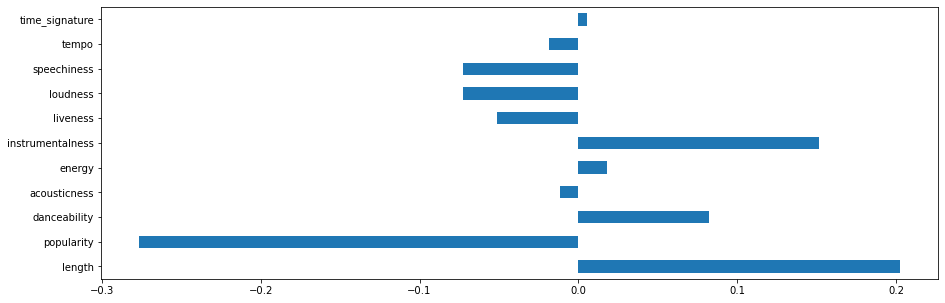

In [8]:
#Correlation Plot between features and target
plt.figure(figsize=(15,5))
df_model.corr().loc['favorite'][:-1].plot.barh()
plt.savefig('Correlation.png')

In [9]:
#Check p-values for significance. P-values greater than .05 mean we fail to reject the null hypothesis that the feature and target have correlation that is significantly close to 0. 
#P-values less than .05 mean we reject the null hypothesis and the feature and target have correlation that is significantly different than 0.
from scipy.stats import pearsonr
from pandas.api.types import is_numeric_dtype
for c in df_model.columns[:-1]:
    if is_numeric_dtype(df_model[c]):
        correlation, pvalue = pearsonr(df_model[c], df_model['favorite'])
        print(f'{c : <40}: correlation: {correlation : .4f}, p-value: {pvalue}, significant: {pvalue <= 0.05}')


length                                  : correlation:  0.2025, p-value: 9.853055633527877e-65, significant: True
popularity                              : correlation: -0.2766, p-value: 2.872691749273048e-121, significant: True
danceability                            : correlation:  0.0821, p-value: 8.901948375274815e-12, significant: True
acousticness                            : correlation: -0.0117, p-value: 0.33178382963487274, significant: False
energy                                  : correlation:  0.0183, p-value: 0.12925326435320422, significant: False
instrumentalness                        : correlation:  0.1517, p-value: 8.901661034408801e-37, significant: True
liveness                                : correlation: -0.0510, p-value: 2.2680765176249375e-05, significant: True
loudness                                : correlation: -0.0724, p-value: 1.741100109037711e-09, significant: True
speechiness                             : correlation: -0.0726, p-value: 1.6201935723051

In [10]:
#Use RFECV package to see which features we can keep
from sklearn.feature_selection import RFECV
from sklearn.tree import DecisionTreeClassifier
DTC = DecisionTreeClassifier()

features = df_model.drop(columns=['favorite', 'track_id'], axis=1)
target = df_model['favorite']
feature_selector = RFECV(DecisionTreeClassifier(), 
              step=1, 
              
              scoring='f1')
feature_selector.fit(features, target)


RFECV(estimator=DecisionTreeClassifier(), scoring='f1')

In [11]:
feature_selector.n_features_

6

In [12]:
features.iloc[:, feature_selector.support_]

,popularity,danceability,instrumentalness,liveness,speechiness,tempo
0,29,0.753,0.85600,0.0692,0.0579,140.011
1,1,0.765,0.82300,0.2430,0.0843,142.007
2,16,0.714,0.66000,0.1230,0.0651,137.981
3,22,0.811,0.82600,0.0695,0.0460,124.000
4,15,0.757,0.91800,0.0869,0.0750,146.994
...,...,...,...,...,...,...
6889,23,0.865,0.52400,0.0369,0.0635,126.113
6890,23,0.959,0.00000,0.1290,0.1460,119.986
6891,0,0.790,0.78600,0.1800,0.0672,127.233
6892,21,0.877,0.00016,0.0960,0.0510,130.013


In [13]:
# Importing required libraries
import sklearn
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_confusion_matrix
from sklearn import metrics 
from sklearn.metrics import f1_score

# Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [14]:
from sklearn.model_selection import train_test_split

X = df_model.drop(columns=['favorite', 'track_id', 'time_signature', 'acousticness', 'tempo', 'energy'])
y = df_model.favorite

x_train, x_test, y_train, y_test = train_test_split(X, y, train_size=0.8, stratify=y)

In [15]:
from pycaret.classification import setup, compare_models
exp_clf = setup(df_model.drop(columns=['track_id', 'time_signature', 'acousticness','tempo']), target='favorite')
best = compare_models(sort='f1')
#Using the F1 as a scoring metric will blend Recall and Precision

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.8725,0.7979,0.3035,0.6789,0.4170,0.3576,0.3952,0.1180
lightgbm,Light Gradient Boosting Machine,0.8669,0.7853,0.3103,0.6234,0.4125,0.3473,0.3750,0.1480
ada,Ada Boost Classifier,0.8665,0.7726,0.2952,0.6361,0.3988,0.3355,0.3688,0.0440
qda,Quadratic Discriminant Analysis,0.8514,0.7288,0.3061,0.5175,0.3816,0.3042,0.3191,0.0080
rf,Random Forest Classifier,0.8672,0.7720,0.2652,0.6517,0.3751,0.3159,0.3567,0.1310
et,Extra Trees Classifier,0.8669,0.7629,0.2543,0.6568,0.3648,0.3071,0.3510,0.0900
dt,Decision Tree Classifier,0.7925,0.6151,0.3608,0.3298,0.3439,0.2212,0.2218,0.0110
nb,Naive Bayes,0.8398,0.7098,0.1981,0.4374,0.2720,0.1964,0.2162,0.0060
lr,Logistic Regression,0.8116,0.7112,0.1516,0.2783,0.1954,0.0995,0.1057,0.6420
lda,Linear Discriminant Analysis,0.8510,0.7230,0.1149,0.5394,0.1879,0.1432,0.1963,0.0080


In [16]:
x_train.head()

,length,popularity,danceability,instrumentalness,liveness,loudness,speechiness
28,260520,71,0.742,0.380000,0.115,-7.694,0.0315
3516,242773,62,0.757,0.485000,0.191,-9.451,0.0432
1953,156992,55,0.741,0.000256,0.599,-8.809,0.0445
4584,179060,60,0.694,0.001230,0.190,-5.933,0.0454
6492,260651,35,0.794,0.000003,0.112,-5.111,0.1330


In [17]:
# Checking for imbalance
y_train.value_counts()

0    4677
1     838
Name: favorite, dtype: int64

In [18]:
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, SVMSMOTE, ADASYN
from imblearn.combine import SMOTEENN, SMOTETomek
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegressionCV


samplers = [
 SMOTE(random_state=42),
 BorderlineSMOTE(random_state=42, kind="borderline-1"),
 BorderlineSMOTE(random_state=42, kind="borderline-2"),
 SVMSMOTE(random_state=42),
 ADASYN(random_state=42),
 SMOTEENN(random_state=42),
 SMOTETomek(random_state=42)
]
for s in samplers:
    x_resampled, y_resampled = s.fit_resample(x_train, y_train)
    lr_model_rs = LogisticRegressionCV(max_iter=1000)
    lr_model_rs.fit(x_resampled, y_resampled)
    ra_score = roc_auc_score(y_test,
    lr_model_rs.predict_proba(x_test)[:, 1])
    print(f'{str(s):<55} {ra_score}')

SMOTE(k_neighbors=5, n_jobs=None, random_state=42, sampling_strategy='auto') 0.737811311495522
BorderlineSMOTE(k_neighbors=5, kind='borderline-1', m_neighbors=10, n_jobs=None,
                random_state=42, sampling_strategy='auto') 0.7380444117286222
BorderlineSMOTE(k_neighbors=5, kind='borderline-2', m_neighbors=10, n_jobs=None,
                random_state=42, sampling_strategy='auto') 0.737561853351327
SVMSMOTE(k_neighbors=5, m_neighbors=10, n_jobs=None, out_step=0.5,
         random_state=42, sampling_strategy='auto', svm_estimator=None) 0.7383674804727436
ADASYN(n_jobs=None, n_neighbors=5, random_state=42, sampling_strategy='auto') 0.7375005111847216
SMOTEENN(enn=None, n_jobs=None, random_state=42, sampling_strategy='auto',
         smote=None) 0.7356929620087516
SMOTETomek(n_jobs=None, random_state=42, sampling_strategy='auto', smote=None,
           tomek=None) 0.7378194904510693


In [19]:
# Train / Split Data
oversample = SVMSMOTE()
x_train, y_train = oversample.fit_resample(x_train, y_train) 

In [20]:
# Checking if imbalance is gone
y_train.value_counts()

1    4677
0    4677
Name: favorite, dtype: int64

## Testing Models

In [21]:
%%time
# Logistic Regression
lr = LogisticRegression(solver='lbfgs', max_iter=400).fit(x_train, y_train)
lr_scores = cross_val_score(lr, x_train, y_train, cv=10, scoring="f1")
print(np.mean(lr_scores))

0.7667113831843331
Wall time: 354 ms


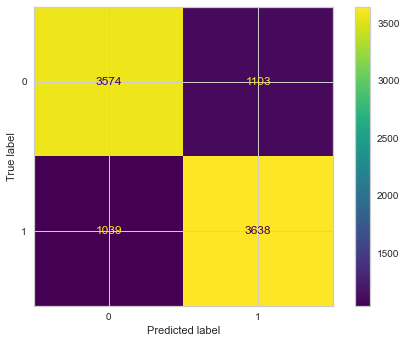

In [22]:
# Logistic Regression confusion matrix
lr_preds = lr.predict(x_train)
plot_confusion_matrix(lr, x_train, y_train)

In [23]:
#Light Gradient Boosting Machine which was the model with the best F1 score
from lightgbm import LGBMClassifier

parameters = {
    'max_depth':[3, 4, 5, 6, 10, 15,20,30],
    'num_leaves':[10,100,300,500,700,1000],
    'min_data_in_leaf': [10,100,300,500,700,1000]
}

lgbm = Pipeline([('CV', GridSearchCV(LGBMClassifier(), parameters, scoring='f1', cv=5))])
lgbm.fit(x_train, y_train)
lgbm.named_steps['CV'].best_params_

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min

{'max_depth': 30, 'min_data_in_leaf': 10, 'num_leaves': 300}

In [30]:
%%time
#Light Gradient Boosting Machine

lgbm = LGBMClassifier(max_depth=30, min_data_in_leaf=10, num_leaves=300).fit(x_train, y_train)
lgbm_scores = cross_val_score(lgbm, x_train, y_train, cv=10, scoring="f1")
np.mean(lgbm_scores)

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min

0.8743711683364506

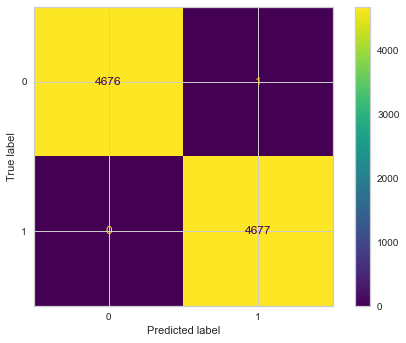

In [31]:
# Light Gradient Booster confusion matrix
plot_confusion_matrix(lgbm, x_train, y_train)

In [32]:
# Hyperparameter optimization for Decision Tree Classifier
parameters = {
    'max_depth':[3, 4, 5, 6, 10, 15,20,30],
}
dtc = Pipeline([('CV',GridSearchCV(DecisionTreeClassifier(), parameters, scoring='f1',cv=10))])
dtc.fit(x_train, y_train)
dtc.named_steps['CV'].best_params_

{'max_depth': 20}

In [33]:
%%time
# Decision Tree Classifier
dtc = DecisionTreeClassifier(max_depth=20).fit(x_train, y_train)
dt_scores = cross_val_score(dtc, x_train, y_train, cv=10, scoring="f1")
np.mean(dt_scores)

Wall time: 827 ms


0.8065622451297161

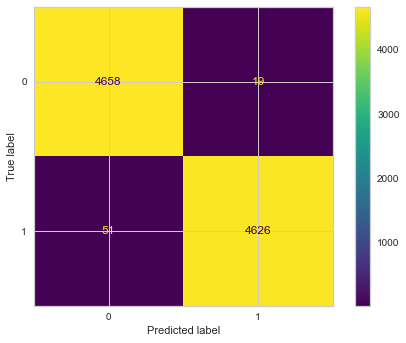

In [34]:
# Decision Tree Classifier confusion matrix
plot_confusion_matrix(dtc, x_train, y_train)

In [35]:
%%time
# Hyperparameter optimization of RandomForestClassifier
parameters = {
    'max_depth':[3, 6,12,15,20],
    'n_estimators':[10, 20,30]
}
clf = Pipeline([('CV',GridSearchCV(RandomForestClassifier(), parameters, cv = 10, scoring='f1'))])
clf.fit(x_train, y_train)
clf.named_steps['CV'].best_params_

Wall time: 36.4 s


{'max_depth': 20, 'n_estimators': 20}

In [36]:
%%time
# RandomForestClassifier
rf = Pipeline([('rf', RandomForestClassifier(n_estimators = 20, max_depth = 20).fit(x_train, y_train))])
rf_scores = cross_val_score(rf, x_train, y_train, cv=10, scoring="f1")
np.mean(rf_scores)

Wall time: 3.63 s


0.8541334331071676

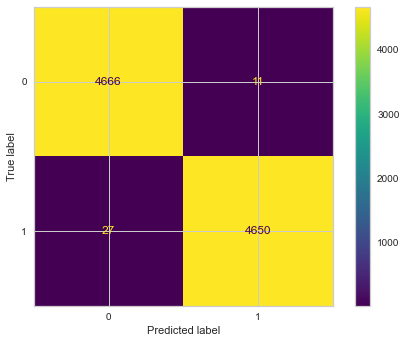

In [37]:
# Random Forest Classifier confusion matrix
plot_confusion_matrix(rf, x_train, y_train)

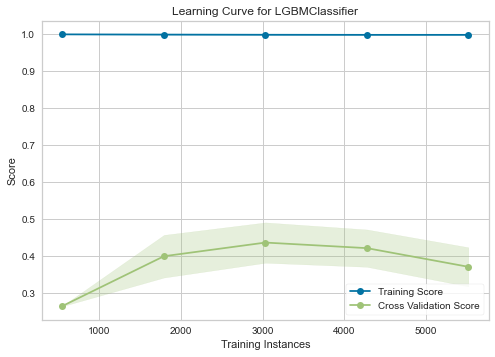

<AxesSubplot:title={'center':'Learning Curve for LGBMClassifier'}, xlabel='Training Instances', ylabel='Score'>

In [38]:
#Learning curve is used to optimize the amount of data to train
#Use a learning curve to see at which point the F1 score levels off based on the amount of data being trained
#This curve shows the F1 score starting to decline around 4250

from yellowbrick.model_selection import LearningCurve
lc = LearningCurve(lgbm, scoring='f1')
lc.fit(X, y)
lc.show()

The Light Gradient Boosting Machine had the best F1 score with Random Forest Classifier, Decision Tree and Logistic Regression following.

Therefore, I will be using the Light Gradient Boosting Machine as my recommendation algorithm.

In [39]:
# Checking for imbalance
y_test.value_counts()

0    1170
1     209
Name: favorite, dtype: int64

In [40]:
# Building a pipeline to use on regular data
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

pipe = make_pipeline(StandardScaler(), LGBMClassifier(max_depth=30, min_data_in_leaf=10, num_leaves=300))
pipe.fit(x_train, y_train)  # apply scaling on training data
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('lgbm', LGBMClassifier(max_depth=30, min_data_in_leaf=10, num_leaves=300))])

pipe.score(x_test, y_test)

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


0.823060188542422

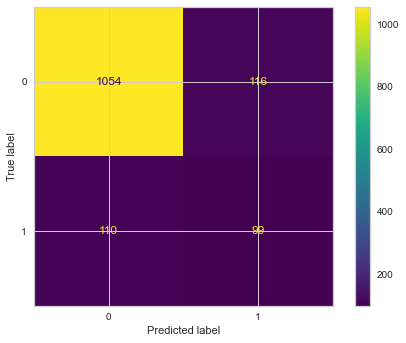

In [41]:
plot_confusion_matrix(rf, x_test, y_test)

In [44]:
# Reloading the original dataframe to test the model on
dfplaylist = pd.read_csv('Track Data for ML\SpotifyJuly22ML.csv')

In [45]:
dfplaylist.shape

(5847, 13)

In [46]:
# Predicting if a song is a favorite
prob_preds = pipe.predict_proba(dfplaylist.drop(['favorite', 'track_id', 'time_signature', 'acousticness', 'tempo', 'energy'], axis=1))
threshold = 0.75 # define threshold here
preds = [1 if prob_preds[i][1]> threshold else 0 for i in range(len(prob_preds))]
dfplaylist['prediction'] = preds

In [47]:
dfplaylist['prediction'].value_counts()

0    5760
1      87
Name: prediction, dtype: int64

In [48]:
import spotipy
import spotipy.util as util
from spotipy.oauth2 import SpotifyClientCredentials
from spotipy import oauth2

In [49]:
# Insert your Spotify username and the credentials that you obtained from spotify developer
from Secret import *

cid = clientID
secret = clientSecret
redirect_uri='http://localhost:7777/callback'
username = 'c0wmilker247'

In [50]:
# Once the Authorisation is complete, we just need to `sp` to call the APIs
scope = 'user-top-read playlist-modify-private playlist-modify-public'
token = util.prompt_for_user_token(username, scope, client_id=cid, client_secret=secret, redirect_uri=redirect_uri)

if token:
    sp = spotipy.Spotify(auth=token)
else:
    print("Can't get token for", username)

In [51]:
# Creating a function that builds a playlist in the user's spotify account
def create_playlist(sp, username, playlist_name, playlist_description):
    playlists = sp.user_playlist_create(username, playlist_name, description = playlist_description)

In [52]:
create_playlist(sp, username, 'Electronic Playlist Recommendation V5', 'The tracks on this playlist were recommended from Spotify\'s electronic playlists with Light Gradient Boost.')

In [53]:
# Function to check if the playlist was created successfully
def fetch_playlists(sp, username):
    """
    Returns the user's playlists.
    """
        
    id = []
    name = []
    num_tracks = []
    
    # Make the API request
    playlists = sp.user_playlists(username)
    for playlist in playlists['items']:
        id.append(playlist['id'])
        name.append(playlist['name'])
        num_tracks.append(playlist['tracks']['total'])

    # Create the final df   
    df_playlists = pd.DataFrame({"id":id, "name": name, "#tracks": num_tracks})
    return df_playlists

In [54]:
fetch_playlists(sp,username).head()

,id,name,#tracks
0,02UZcdcWMvGKpeUmBvpLJh,Electronic Playlist Recommendation V5,0
1,2gy6x2RldlThBz2vDJisx5,songs i’d fight scotus to,48
2,3TE6FE9qSBXosbOj7Z88zW,July ‘22,18
3,1m4WUMXgm1q6TRbSdBdYaX,June ‘22,10
4,2Zd2wRYKjlIaQYou1rDtwB,i’m almost a lawyer party (boys vers),14


In [55]:
# Getting the playlist ID of the most recently made playlist so we can add songs to it later
playlist_id = fetch_playlists(sp,username)['id'][0]

In [56]:
# Function to add selected songs to playlist
def enrich_playlist(sp, username, playlist_id, playlist_tracks):
    index = 0
    results = []
    
    while index < len(playlist_tracks):
        results += sp.user_playlist_add_tracks(username, playlist_id, tracks = playlist_tracks[index:index + 75])
        index += 75

In [57]:
# Adding songs to playlist
list_track = dfplaylist.loc[dfplaylist['prediction']  == 1]['track_id']
enrich_playlist(sp, username, playlist_id, list_track)